# Validation CNN Model
The CNN model is validated using the test dataset.  
The validation is similar to data pipeline. The difference is that the validation will compare the output of the model with the annotations of the test dataset.  
Beside the model itself, the performance of the model also depends on the resize ratio and the threshold of the voting.

## Output
The output of the validation is a image with the output of the model.
The true positives are marked in green, the false positives in red. There is a blue line in the video to simulate the position of the GPR instrument. The output files include:
- `validation_CNN.jpg`: The GPR image same as the input image, but with the label generated by the model.
- `validation_CNN.mp4`: The video recording the labeling process with the size of original image.
- `moving_validation_CNN.mp4`: The video recording the labeling process with fixed size of the frame that is 16:9.

## Metrics
The metrics used to validate the model are:
- Recall
- Area Precision

A true positive is a prediction that lies within the range of the hyperbola in annotation. A false positive is a prediction that does not lie within the range of the hyperbola in annotation.  
Recall is calculated as the number of detected hyperbolas divided by the total number of hyperbolas in the image. A detected hyperbola means a true positive prediction lies within the range of the hyperbola in annotation.  
Area precision is calculated as the number of true positives divided by the number of true positives plus the number of false positives.

## Recording
There are two function to record the validation.
- `validate_label_video` records the validation with the size of original image.
- `moving_window_video` records the validation with fixed size of the frame that is 16:9.

If the width of the original image is larger than 2000 pixels, the `moving_window_video` function is recommended.  
If the width of the original image too small to maintain the aspect ratio of 16:9, the `validate_label_video` function is recommended.

In [1]:
import copy
import cv2
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow import keras
import xml.etree.ElementTree as ET

In [2]:
# functions for parsing CVAT annotations
def image_names_parser(path):
    tree = ET.parse(f'{path}/annotations.xml')
    root = tree.getroot()
    image_names = []
    for image in root.findall('image'):
        image_names.append(image.get('name'))
    return image_names

def labels_parser(path, image_name):
    tree = ET.parse(f'{path}/annotations.xml')
    root = tree.getroot()

    labels = {}
    for i, label in enumerate(root.iter('label')):
        labels[label.find('name').text] = i

    image_node = None
    for image in root.findall('image'):
        if image.get('name') == image_name:
            image_node = image

    boxs = []
    coordinates = ['ytl', 'xtl', 'ybr', 'xbr']
    for i in range(len(labels)):
        boxs.append([])
    for box in image_node.findall('box'):
        points = []
        for coordinate in coordinates:
            points.append(int(box.get(coordinate).split(".")[0]))
        boxs[labels[box.get('label')]].append(points)

    return boxs

In [3]:
def check_out_of_box(sliding_window, box):
    if sliding_window[2] < box[0] or sliding_window[0] > box[2]:
        return True
    if sliding_window[3] < box[1] or sliding_window[1] > box[3]:
        return True
    return False

def check_box(sliding_window, box, overlapping):
    if check_out_of_box(sliding_window, box):
        return False
    
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    overlap_area = (min(sliding_window[2], box[2]) - max(sliding_window[0], box[0])) * (min(sliding_window[3], box[3]) - max(sliding_window[1], box[1]))
    if overlap_area / box_area < overlapping:
        return False    
    
    return True

In [4]:
# calculate the voting result based on the index of the sliding window
def label_voting(validate_result, threshold, image_shape, sliding_window_size, step, image_start):
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)
    voting = np.zeros((height + 4, width + 4))
    total = np.zeros((height + 4, width + 4))

    for j in range(height):
        for i in range(width):
            p = validate_result[i + j * width, 1]
            voting[j : j + 5, i : i + 5] += np.ones((5, 5)) * p
            total[j : j + 5, i : i + 5] += np.ones((5, 5))
    voting /= total
    voting = np.where(voting > threshold, 1, 0)
    return voting

## Load CNN Model

In [5]:
model_name = "saved_models/hyperbola_vgg2.keras"
model = keras.models.load_model(model_name, compile = False)
model.compile()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      832       
                                                                 
 dropout_6 (Dropout)         (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      51264     
                                                                 
 dropout_7 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                  

## Parameters Setting
The parameters of the validation are:
- `IMAGE_START`, `AXIS_ZERO`:　The start position of the image containing signal from the surface.
- `image_name`: The name of the GPR image.
- `label_path`: The path of the annotation.
- `scale_percent`: The resize ratio of the image.

In [6]:
start_time = time.time()
# IMAGE_START excludes the left axis of the image.
# AXIS_ZERO excludes the top axis of the image. For 1st dataset and 2nd dataset, this also excludes
# the first few nano seconds of the image that receive no signal from the surface.

# Boundary constant of images
IMAGE_START = 64
AXIS_ZERO = 44     # 1st dataset, 2nd dataset: 121, 3rd dataset: 44

image_name = "ARR7_350_230324__001 P_31111111.JPG"
image_path = f"../data_preprocessing/unprocessed_images/{image_name}"
# label_path = '../data_preprocessing/annotations/1stdataset20230420' # 1st dataset
# label_path = '../data_preprocessing/annotations/2ndDataset20230421' # 2nd dataset
label_path = '../data_preprocessing/annotations/3rdDataset20230420' # 3rd dataset
labels = labels_parser(label_path, image_name.replace('.JPG', '_processed.JPG'))

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

# scale down
scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
IMAGE_START = int(IMAGE_START * scale_percent / 100)
AXIS_ZERO = int(AXIS_ZERO * scale_percent / 100)
image_start = [AXIS_ZERO, IMAGE_START]

height = math.ceil((img.shape[0] - sliding_window_size - image_start[0]) / step)
width = math.ceil((img.shape[1] - sliding_window_size - image_start[1]) / step)
number_image = height * width

In [7]:
def validate_label(image, labels, voting, scale_percent, image_name, file_name='output.jpg'):
    img = copy.deepcopy(image)

    print(f'evaluating {image_name}...')
    feature_types = ['small strong hyperbola', 'small weak hyperbola', 'noise', 'large strong hyperbola', 'large weak hyberbola', 'no feature']
    image_shape = img.shape
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)

    print(voting.shape)
    no_feature_index = len(feature_types) - 1
    label_check = np.zeros(len(feature_types))
    total_label = 0
    
    hyperbola_feature = [0, 1, 3, 4]
    for k in hyperbola_feature:
        for box in labels[k]:
            box_index = []
            # transform the image coordinates to the index of the sliding window
            for i, b in enumerate(box):
                if i % 2 == 0:
                    box_index.append((b * scale_percent / 100 - image_start[0]) / step)
                else:
                    box_index.append((b * scale_percent / 100 - image_start[1]) / step)
            start = [math.floor(box_index[0]), math.floor(box_index[1])]
            end = [math.ceil(box_index[2] + 1), math.ceil(box_index[3] + 1)]
            is_feature = False
            for j in range(max(start[0], 0), min(end[0] + 4, height)):
                for i in range(max(start[1], 0), min(end[1] + 4, width)):
                    # voting[j, i] = 1 if false positive, 2 if true positive
                    if voting[j, i] == 1 and not check_out_of_box([j, i, j + 1, i + 1], box_index):
                        voting[j, i] = 2
                        is_feature = True
            if is_feature:
                label_check[k] += 1

        print(f'{feature_types[k]} recall: {int(label_check[k])} / {len(labels[k])} ( {label_check[k] / len(labels[k]) * 100:.1f} % )')
        total_label += len(labels[k])
    print(f'overall recall: {int(sum(label_check))} / {total_label} ( {int(sum(label_check)) / total_label * 100:.1f} % )')

    precision = 0
    total = 0
    for j in range(height + 4):
        for i in range(width + 4):
            if voting[j, i] > 0:
                total += 1
                if voting[j, i] == 2:
                    precision += 1
    if (total == 0):
        print('area precision not available')
    else:
        print(f'area precision: {precision / total * 100:.1f} %')

    box_width = 2
    for j in range(height + 4):
        for i in range(width + 4):
            box = [image_start[1] + i * step, image_start[0] + j * step, image_start[1] + (i + 1) * step, image_start[0] + (j + 1) * step]
            # label the box with different color. Red for false positive, and green for true positive.
            if voting[j, i] == 1:
                color = np.array([229, 0, 0]) # red
            elif voting[j, i] == 2:
                color = np.array([21, 176, 26]) # green

            if voting[j, i] > 0:
                img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
                img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
                img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
                img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
    plt.imshow(img)
    plt.imsave(file_name, img)

## Image Preprocessing
Crop the image into 200 x 200 pixels.

In [8]:
count = 0
sub_images = np.zeros(shape=(number_image, 200, 200), dtype='float32')

for j in range(height):
    for i in range(width):
        sliding_window = [image_start[0] + j * step, image_start[1] + i * step, image_start[0] + sliding_window_size + j * step, image_start[1] + sliding_window_size + i * step]
        sub_img = img[sliding_window[0]:sliding_window[2], sliding_window[1]:sliding_window[3]]
        rgb_weights = [0.2990, 0.5870, 0.1140]
        sub_img = np.dot(sub_img[...,:3], rgb_weights)
        sub_img = np.array(sub_img)

        sub_images[count] = sub_img / 255
        count += 1
        
print(sub_images.shape)

(12416, 200, 200)


In [9]:
validate_result = model.predict(sub_images)
print(validate_result.shape)

388/388 [==============================] - 292s 752ms/step
(12416, 2)


## Performance Evaluation
The performance of the model is evaluated by the metrics.  
Set the threshold of the voting in `label_voting` function.

evaluating ARR7_350_230324__001 P_31111111.JPG...
(20, 780)
small strong hyperbola recall: 10 / 24 ( 41.7 % )
small weak hyperbola recall: 13 / 30 ( 43.3 % )
large strong hyperbola recall: 5 / 6 ( 83.3 % )
large weak hyberbola recall: 8 / 20 ( 40.0 % )
overall recall: 36 / 80 ( 45.0 % )
area precision: 38.5 %
execution time: 315.22 seconds
image size: (847, 31280)


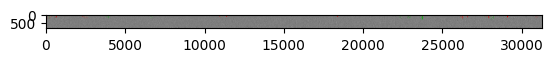

In [10]:
voting = label_voting(validate_result, 0.25, img.shape, sliding_window_size, step, [AXIS_ZERO, IMAGE_START])
validate_label(img, labels, voting, scale_percent, image_name, file_name='validation_CNN.jpg')
print(f'execution time: {time.time() - start_time:.2f} seconds')
print(f'image size: {(img.shape[0], img.shape[1])}')

## Recording the labeling process

In [11]:
def validate_label_video(image, voting, file_name='output.mp4'):
    img = copy.deepcopy(image)
    print('recording video...')
    image_shape = img.shape
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)
    # the video is 30 fps with and size of the image
    video_writer = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (image_shape[1], image_shape[0]))
    voting_i = 0
    box_width = 2
    for i in range(image_start[1], image_shape[1], 5):
        video_color = np.array([223, 67, 3]) # blue
        img[:, i - 6:i - 3, :] = image[:, i - 6:i - 3, :]
        img[:, i - 1:i + 2, :] = np.ones_like(img[:, i - 1:i + 2, :]) * video_color
        if i > image_start[1] + (voting_i + 1) * step:
            for voting_j in range(height + 4):
                box = [image_start[1] + voting_i * step, image_start[0] + voting_j * step, image_start[1] + (voting_i + 1) * step, image_start[0] + (voting_j + 1) * step]
                if voting[voting_j, voting_i] > 0:
                    if voting[voting_j, voting_i] == 1:
                        video_color = np.array([0, 0, 229]) # red
                    elif voting[voting_j, voting_i] == 2:
                        video_color = np.array([26, 176, 21]) # green

                    img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * video_color
                    img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * video_color
                    img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * video_color
                    img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * video_color
            voting_i += 1
        video_writer.write(img)

    video_writer.release()
    cv2.destroyAllWindows()
    print('video saved')

In [12]:
validate_label_video(img, voting, file_name='validation_CNN.mp4')

recording video...
video saved


In [13]:
def moving_window_video(image, voting, file_name='output.mp4'):
    img = copy.deepcopy(image)
    print('recording video...')
    image_shape = img.shape
    frame = [image_shape[0], int(image_shape[0] * 16 / 9)]
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    # the video is 30 fps with and fixed size of the image (16:9)
    video_writer = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'MP4V'), 30, (frame[1], frame[0]))
    voting_i = 0
    box_width = 2
    for i in range(image_start[1], image_shape[1], 10):
        video_color = np.array([223, 67, 3]) # blue
        img[:, i - 11:i - 8, :] = image[:, i - 11:i - 8, :]
        img[:, i - 1:i + 2, :] = np.ones_like(img[:, i - 1:i + 2, :]) * video_color
        if i > image_start[1] + (voting_i + 1) * step:
            for voting_j in range(height + 4):
                box = [image_start[1] + voting_i * step, image_start[0] + voting_j * step, image_start[1] + (voting_i + 1) * step, image_start[0] + (voting_j + 1) * step]
                if voting[voting_j, voting_i] > 0:
                    if voting[voting_j, voting_i] == 1:
                        video_color = np.array([0, 0, 229]) # red
                    elif voting[voting_j, voting_i] == 2:
                        video_color = np.array([26, 176, 21]) # green

                    img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * video_color
                    img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * video_color
                    img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * video_color
                    img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * video_color
            voting_i += 1
        if i - int(frame[1] * 2 / 3) < 0:
            video_writer.write(img[:, :frame[1], :])
        elif i + int(frame[1] * 1 / 3) > image_shape[1]:
            video_writer.write(img[:, image_shape[1] - frame[1]:image_shape[1], :])
        else:
            video_writer.write(img[:, i - int(frame[1] * 2 / 3):i + int(frame[1] * 1 / 3), :])

    video_writer.release()
    print('video saved')

In [14]:
moving_window_video(img, voting, file_name='moving_validation_CNN.mp4')

recording video...
video saved
